<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# High Dimensional & Deep Learning : Image classification  on MNIST dataset.

## Objectives
In this TP you will learn to : 
* Write multilayer perceptron and convolutional network with `Keras`and `Tensorflow`
* Understand how `convolutional`, `max pooling`, `stride` and `padding`layers work.
* Use these model to use classification problem on image data.

## Libraries

In [47]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

import pandas as pd
import numpy as np
import time

tf.compat.v1.keras

import tensorflow.keras.utils as ku
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.preprocessing.image as kpi


from sklearn.metrics import confusion_matrix

This code lines allow you to check if your computer is using CPU or GPU ressources. <br>
**Warning** : You won't be able to use GPU if another notebook is open and using GPU.

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8934220024667888617
]


## Dataset 

The dataset that will be used in this TP are the [MNIST DataBase](http://yann.lecun.com/exdb/mnist/).<br>
They are composed of 70.000 images (60.000 for learning, 10.000 for test) of 28x28 pixels of handwritten digits from 0 to 9.<br>

These data are directly available on the `Keras` library.

In [19]:
from tensorflow.keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
N_train, N_x_pixels, N_y_pixels = X_train.shape
N_test = X_test.shape[0]
N_classes = len(set(Y_train))

print("Train data : %d images  (%d/%d pixels)" %(N_train, N_x_pixels, N_y_pixels))
print("Test data : %d images  (%d/%d pixels)" %(N_test, N_x_pixels, N_y_pixels))

Train data : 60000 images  (28/28 pixels)
Test data : 10000 images  (28/28 pixels)


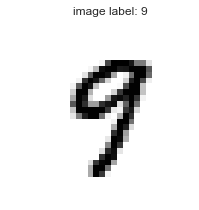

In [11]:
sample_index = 45
fig =plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.imshow(X_train[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
ax.set_title("image label: %d" % Y_train[sample_index])
ax.grid(False)
ax.axis('off')
plt.show()

### Image example

## Image classification with Multi Layer Perceptron model.

We will first try to learn an image classifier with a MLP model with the following architecture.

* A Dense layer with 128 neurons and *relu* activation function
* A Dropout Layer with 20% drop rate
* A Dense layer with 128 neurons and *relu* activation function
* A Dropout Layer with 20% drop rate
* A Dense layer with 10 neurons (Number of classes ) and *softmax* activation function

### Data format

Some modification are required on the data to used them with our model. 
The first layer is a Dense Layer, which handle 1D vectors as an input. We must first reshape the 2D 28x28 images as a 1D $28*28=784$ vectors.

In [38]:
X_train_flatten = X_train.reshape((N_train, N_x_pixels*N_y_pixels))
X_test_flatten = X_test.reshape((N_test, N_x_pixels*N_y_pixels))
N_dim_flatten = X_train_flatten.shape[1]
print("Dimensions of flatten train images : %d X %d" %(X_train_flatten.shape))
print("Dimensions of flatten test images : %d X %d" %(X_test_flatten.shape))

Dimensions of flatten train images : 60000 X 784
Dimensions of flatten test images : 10000 X 784


### Architecture 

In [39]:
# Définition du réseau
model = km.Sequential()
model.add(kl.Dense(128, activation='relu', input_shape=(N_dim_flatten,)))
model.add(kl.Dropout(0.2))
model.add(kl.Dense(128, activation='relu'))
model.add(kl.Dropout(0.2))
model.add(kl.Dense(N_classes, activation='softmax'))
# Réumé
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


**Q** The summary methods display the number of Param/weigths of the model. Retrieve these values with the formula seen in class.

### Training

You will now instantiate yout model by defining :
* A optimizer : `RMSprop`
* a loss function : `Categorical crossentropy`
* Metric : This argument is an options, it allows to compute the metric you want to check the evolution of the training. Here we choose to compute the accuracy during the training

**Note** : In Keras you can choose either "sparse_categorical_crossentropy", "categorical_crossentropy" loss or . The former handel 1D (NX1) vectors where each entry contains the label of the data, i.e [0,3,5,9,3,4,...]. The latter handle only one-hot encoding of this vector, ie a 2D vectors (NXN_classes) matrices. Keras has a `to_categorical`functions which allows to convert a vector to his one-hot encoding representation.

In [40]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=ko.RMSprop(),
              metrics=['accuracy'])

In [41]:
ts = time.time()
history = model.fit(X_train_flatten, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test_flatten, Y_test))
te = time.time()
t_train_mpl = te-ts

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3717 - acc: 0.8898 - val_loss: 0.1586 - val_acc: 0.9510
Epoch 2/10
60000/60000 [==============================] - 1s 17us/sample - loss: 0.1685 - acc: 0.9493 - val_loss: 0.1142 - val_acc: 0.9642
Epoch 3/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.1290 - acc: 0.9617 - val_loss: 0.0916 - val_acc: 0.9728
Epoch 4/10
60000/60000 [==============================] - 1s 17us/sample - loss: 0.1072 - acc: 0.9681 - val_loss: 0.0961 - val_acc: 0.9703
Epoch 5/10
60000/60000 [==============================] - 1s 17us/sample - loss: 0.0940 - acc: 0.9722 - val_loss: 0.0872 - val_acc: 0.9733
Epoch 6/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0856 - acc: 0.9745 - val_loss: 0.0765 - val_acc: 0.9775
Epoch 7/10
60000/60000 [==============================] - 1s 17us/sample - loss: 0.0769 - acc: 0.9771 - val_loss: 0.

### Résultats

Test loss: 0.0775116760097997
Test accuracy: 0.9793
Time Running: 11.09 seconds


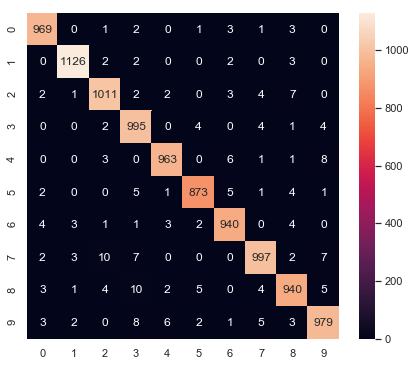

In [42]:
score_mpl = model.evaluate(X_test_flatten, Y_test, verbose=0)
predict_mpl = model.predict(X_test_flatten)
print('Test loss:', score_mpl[0])
print('Test accuracy:', score_mpl[1])
print("Time Running: %.2f seconds" %t_train_mpl )
fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_mpl.argmax(1))), annot=True, fmt="d")


**Question** What can you say about these results?

**Exercise** Normalize the data in order that they have values between 0 and 1 and run again the learning. What can you say about these results?

## Convolutional Layers

In this part we will use convolution layers to build a convolutional classifier.


#### Data

The convolution architecure expect images and not 1D vectors. However, some data formating are again required.

A third dimension is required : the `channels` dimension which will allow to describe each pixel. In pour case this dimension's size is only 1 because the images are only defined with grey scale. However for colours images, each pixel is coded with several values (Images are generally encoded with 3 values (RGB channels)). 

Hence, we need to reshape the images from a 28x28 dimension to a 28X28X1 dimensions

In [45]:
X_train_conv = np.expand_dims(X_train,axis=-1)
X_test_conv = np.expand_dims(X_test,axis=-1)
X_train_conv.shape

(60000, 28, 28, 1)

### Edge detection

We will first check the transformation apply by a convolution layer.

In the following coded we define a convolutional network define of only one filter for which we manually defined the weights.

In [54]:

conv_filter = np.array([
        [0.2, -0.2, 0],
        [0.2, -0.2, 0],
        [0.2, -0.2, 0],
    ])

def my_init_filter(shape, conv_filter = conv_filter, dtype=None, partition_info=None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array
my_init_filter(0).shape

conv_edge = km.Sequential([
    kl.Conv2D(kernel_size=(3,3), filters=1, kernel_initializer=my_init_filter, input_shape=(28, 28, 1))   
])

 **Q** Note that in  `my_init_filter` two dimensions have been added to the conv filter. What these dimensions represent?
 
 The following code allows to display the image, the filtern and the convoluted image.

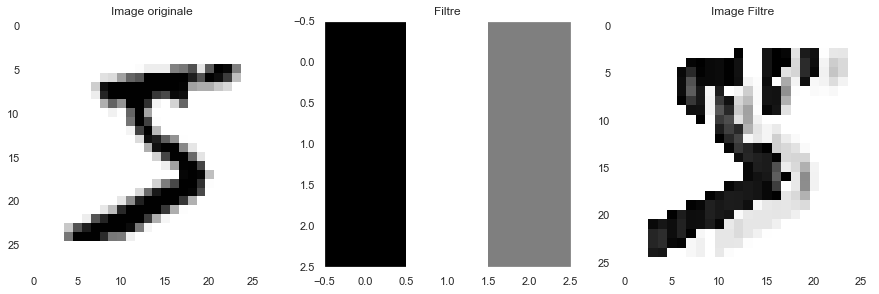

In [55]:
img_in = np.expand_dims(x, 0)
img_out = conv_edge.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0], cmap="binary")
ax0.set_title("Image originale")
ax0.grid(False)

norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8), cmap="binary")
ax1.set_title("Filtre")
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8), cmap="binary")
ax2.set_title("Image Filtre")
ax2.grid(False)


**Q** What do you see? Are the output image coherent according to the designed filter

**Exercise** Change the code in order to test different filter (to detect horizontal edge, etc...)

### Strides and Padding

We will now study the effect on `strides`et `padding` arguments on the image.


In [57]:
conv_filter = np.array([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
    ])

def my_init_filter(shape, conv_filter = conv_filter, dtype=None, partition_info = None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array
my_init_filter(0).shape

conv_sp = km.Sequential([
    kl.Conv2D(kernel_size=(3,3), filters=1, kernel_initializer=my_init_filter, input_shape=(28, 28, 1),
           strides=2, padding="SAME") ])

**Q** What is the effect of the convolutional filter definad here.

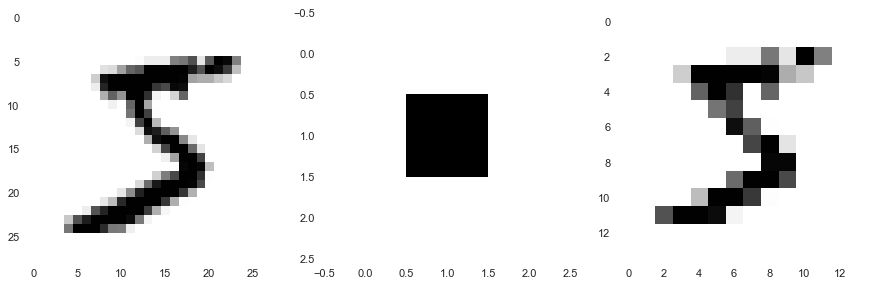

In [58]:
img_in = np.expand_dims(x, 0)
img_out = conv_sp.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax0.grid(False)

norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8),
           cmap="binary");
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax2.grid(False)

**Exercise** Check the dimension of the output images. Are they coherent? <br>
**Exercise** Change both *strides* and *padding* arguments and understant the effect of this change.

### Max Pooling

**Exercice** Write a similar coded than above to check and understand the behaviour of the `max pooling` layer.

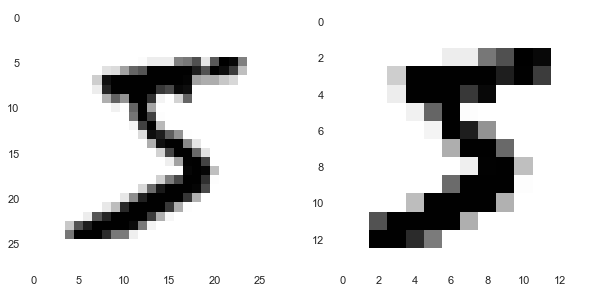

In [62]:
# %load solutions/max_pooling.py


**Questions** What are the dimension of the output image? Is this normal?

## *Convolutional Network (ConvNet)*

We will now build convolutional network and see the performance on this kind of model on  iamge classification problem.

### LeNet5

On teste dans un premier temps le modèle LeNet5 proposer par LeCun et al.

In [63]:
LeNet5model = km.Sequential()
LeNet5model.add(kl.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'tanh',
input_shape = (28,28,1)))
LeNet5model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
LeNet5model.add(kl.Conv2D(filters = 16, kernel_size = 5,strides = 1, activation = 'tanh'))
LeNet5model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
LeNet5model.add(kl.Flatten())
LeNet5model.add(kl.Dense(units = 120, activation = 'tanh'))
LeNet5model.add(kl.Dense(units = 84, activation = 'tanh'))
LeNet5model.add(kl.Dense(units = 10, activation = 'softmax'))

LeNet5model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_7 (Dense)              (None, 84)                10164     
__________

**Exercise** Retrieve 'manually' the number of paramters of thise model.

**Question** What can you cabout the total number of parameters compare with the MLP model defined before? Wich layer have the most parameter?

In [65]:
# Apprentissage
LeNet5model.compile(loss="sparse_categorical_crossentropy",
              optimizer=ko.Adadelta(),
              metrics=['accuracy'])
ts=time.time()
LeNet5model.fit(X_train_conv, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_conv, Y_test))
te=time.time()
t_train_conv = te-ts

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.2504 - acc: 0.9261 - val_loss: 0.0980 - val_acc: 0.9706
Epoch 2/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0833 - acc: 0.9740 - val_loss: 0.0699 - val_acc: 0.9775
Epoch 3/10
60000/60000 [==============================] - 8s 129us/sample - loss: 0.0588 - acc: 0.9816 - val_loss: 0.0662 - val_acc: 0.9801
Epoch 4/10
60000/60000 [==============================] - 8s 130us/sample - loss: 0.0472 - acc: 0.9851 - val_loss: 0.0572 - val_acc: 0.9818
Epoch 5/10
60000/60000 [==============================] - 8s 135us/sample - loss: 0.0383 - acc: 0.9882 - val_loss: 0.0598 - val_acc: 0.9818
Epoch 6/10
60000/60000 [==============================] - 8s 140us/sample - loss: 0.0299 - acc: 0.9908 - val_loss: 0.0551 - val_acc: 0.9823
Epoch 7/10
60000/60000 [==============================] - 8s 135us/sample - loss: 0.0250 - acc: 0.9923 - val_l

**Q** Why is the trianing time longer?

#### Résultats

Test loss: 0.05596719617132912
Test accuracy: 0.9838
Time Running: 80.93 seconds


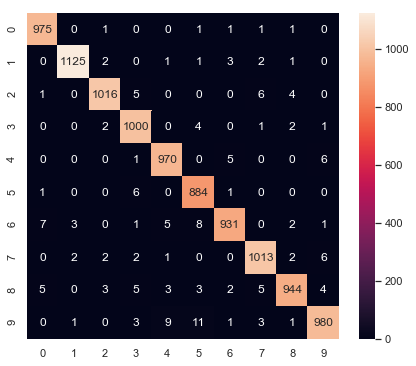

In [66]:
score_conv = LeNet5model.evaluate(X_test_conv, Y_test, verbose=0)
predict_conv = LeNet5model.predict(X_test_conv)
print('Test loss:', score_conv[0])
print('Test accuracy:', score_conv[1])
print("Time Running: %.2f seconds" %t_train_conv )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_conv.argmax(1))), annot=True, fmt="d")


### More complex architecture

#### Network

We will now design a more complex architecture to try to improve the results of the classification :

* A Conv2D layer with 32-3X3 filters and a `Relu`activation function.
* A Conv2D layer with642-3X3 filters and a `Relu`activation function.
* A MaxPooling layer with 2X2 wingodw.
* A Dropout layer with a 25% drop rate.
* A flatten layer.
* A Dense layer with 128 neurons  and a `Relu` activation function.
* A Dropout layer with a 50% drop rate.
* A Dense layer with 10 neurons  and a `softmax` activation function.


**Exercise** write these models and train it.

In [ ]:
# solutions/mnist_conv_architecture.py

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
__________

In [ ]:
score_conv = model.evaluate(X_test_conv, Y_test_cat, verbose=0)
predict_conv = model.predict(X_test_conv)
print('Test loss:', score_conv[0])
print('Test accuracy:', score_conv[1])
print("Time Running: %.2f seconds" %t_train_conv )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_conv.argmax(1))), annot=True, fmt="d")

**Q** Comments the results.

**Q** How to improve it?